In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt

# Programming Exercise, GPs pt. 2

### Special kernel

In [11]:
## kernel functions ## 

def gaussian_kernel(X,Xprime, gamma=2):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)

def special_kernel(X,Xprime, eta):
    a = eta[0]
    b = eta[1]
    K = (1+X@Xprime.T)**2 + a * np.multiply.outer(np.sin(2*np.pi*X.reshape(-1)+b),np.sin(2*np.pi*Xprime.reshape(-1)+b))
    return K

In [25]:
# B) todo: implement this
def negLogLikelihood(X, y, params, kernel):
    noise_var = params[0] # noise_y
    eta = params[1:] # eta = (a, b)
    
    # calculate the negative loglikelihood (See section 6.3 in the lecture notes) - page 42
    
    # transform X 
    X = X[:, np.newaxis]
    epsilon = 1e-6  # Small regularization term for numerical stability

    # Kernel matrix and regularized diagonal
    K_S = kernel(X, X, eta) + (noise_var + epsilon) * np.eye(len(X)) # K(S,S)
    
    # compute G 
    G = np.linalg.inv(noise_var**2 * np.eye(len(X)) + K_S) #(sigma_y^2*I + K(S))^-1
    
    # compute alpha = G*y
    alpha = G @ y

    # Compute the log determinant of K log det(sigma_y^2*I + K(S)) to check covariance matrices are positive definite, so we don't suffer from numerical difficulties
    sign, log_det = np.linalg.slogdet(noise_var**2 * np.eye(len(X)) + K_S)
    if sign <= 0:
        raise ValueError("Matrix determinant is non-positive, cannot compute log.")
    log_det_K = log_det

    # Negative log-likelihood
    nll = 0.5 * y.T @ alpha + 0.5 * log_det_K + 0.5 * len(y) * np.log(2 * np.pi)
    return nll # todo: return the negative loglikelihood
    
def optimize_params(X, y, ranges, kernel, Ngrid):
    opt_params = opt.brute(lambda params: negLogLikelihood(X, y, params, kernel), ranges, Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    return noise_var, eta

def conditional(X, y, X_predict, noise_var, eta, kernel):
    """ Condition on noise measurements """
    # See eq. 75 in the lecture notes. Note that there is a small error: Instead of (S) it should be K(S)
    
    # transform X 
    X = X[:, np.newaxis]
    X_predict = X_predict[:, np.newaxis]
    
    # calculate kernel matrices used in eq 75 
    K_S = kernel(X, X, eta) # K(S, S)
    K_star = kernel(X, X_predict, eta)  # K(S, X*)
    K_star_star = kernel(X_predict, X_predict, eta)  # K(X*, X*)
    
    # compute G 
    G = np.linalg.inv(noise_var**2 * np.eye(len(X)) + K_S) #(sigma_y^2*I + K(S))^-1
    
    # compute alpha = G*y
    alpha = G @ y
    
    # Use eq. 75 from lecture notes to calculate mu_star and sigma_star for new x
    mustar = K_star.T @ alpha # kernel(S, x∗)^T*alpha
    Sigmastar = K_star_star - K_star.T @ G @ K_star # kernel(x∗, x∗) − kernel(S, x∗)^T*G*kernel(S, x∗)
    
    return mustar, Sigmastar # return mean and covariance matrix

Load data

In [26]:
#load and normalize Mauna Loa data 
data = np.genfromtxt('/opt/streamline/jmj/Courses/PLM/co2_mm_mlo.csv', delimiter=',')
#10 years of data for learning
X = data[:120,2]-1958
y_raw = data[:120,3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw-y_mean)/y_std
#the next 5 years for prediction
X_predict = data[120:180,2]-1958
y_predict = data[120:180,3]

Run GP 

In [27]:
# optimize parameters and use special kernel 

ranges =  ((1e-4, 10), (1e-2, 5), (0.1, 2 * np.pi)) # # Ranges for noise_var, and eta (a, and b)
Ngrid = 10
kernel = special_kernel
noise_var, eta = optimize_params(X, y, ranges, kernel, Ngrid)
print(noise_var, eta)

1.1112 [0.56444444 2.84808236]


In [28]:
# condition 
prediction_mean_gp, Sigma_gp = conditional(X, y, X_predict, noise_var, eta, kernel)

var_gp = np.diag(Sigma_gp) # We only need the diagonal term of the covariance matrix for the plots.

Plot results

In [29]:
# Compute 95% confidence interval
# Postprocess mean for plotting
yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp * y_std**2
lower = yout_m - 1.96 * np.sqrt(yout_v)
upper = yout_m + 1.96 * np.sqrt(yout_v)

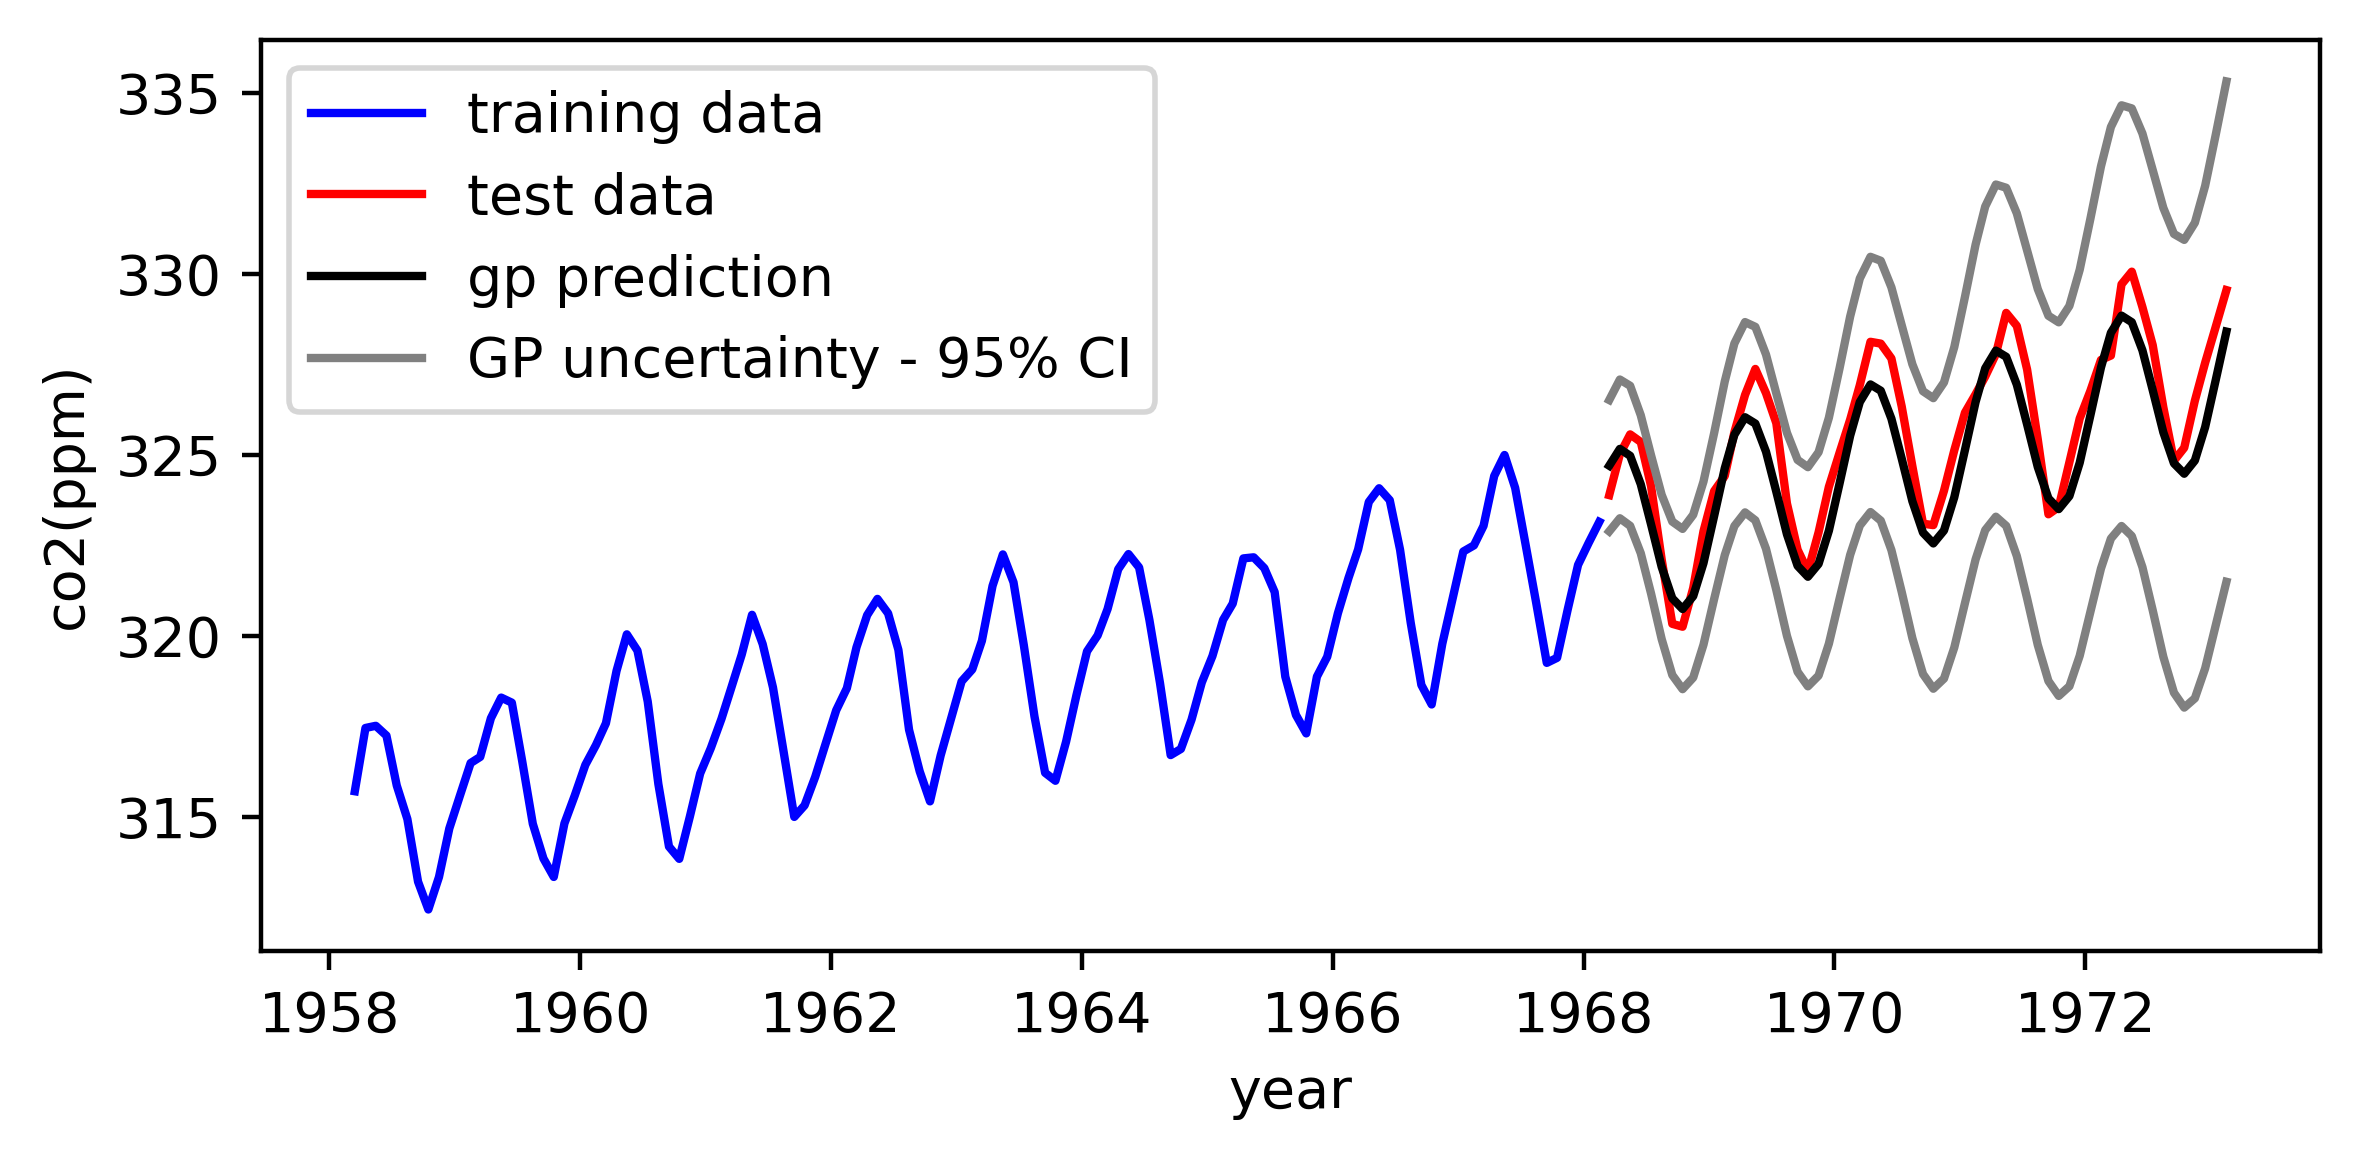

In [30]:
#plotting code for your convenience
plt.figure(dpi=400,figsize=(6,3))
plt.plot(X + 1958, y_raw, color='blue', label='training data')
plt.plot(X_predict + 1958, y_predict, color='red', label='test data')
# prediction
plt.plot(X_predict + 1958, yout_m, color='black', label='gp prediction')
plt.plot(X_predict + 1958, upper, color='grey', label='GP uncertainty - 95% CI')
plt.plot(X_predict + 1958, lower, color='grey')
plt.xlabel("year")
plt.ylabel("co2(ppm)")
plt.legend()
plt.tight_layout()
plt.show()